In [3]:
import os 
import random 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss,L1Loss

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import KNeighborsClassifier

from pytorch_metric_learning.losses import ContrastiveLoss

In [4]:
from src.datasets.data import PAMAP2Reader
# from src.datasets.dataset import PAMAP2Dataset

from src.models.ts_transformer import RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 
from src.utils.losses import SupConLoss

from src.utils.analysis import action_evaluator

In [5]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt 
import plotly.express as px

In [6]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "RelativeGlobalAttention",
    "sem-space": 'attr',
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "lr": 0.001,
    "ae_lr": 0.0001,
    "imu_lr": 0.0004,
    "ae_alpha": 0.7,
    "imu_alpha": 0.3,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 128, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---

In [7]:
class Model6a(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(Model6a, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu  # _get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out1 = self.DenseL2(out)   
        out = self.logist(out1)     
        return out, out1

---

In [8]:

class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.concat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32, device='cpu'):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.device = device

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)

                        
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((self.batch_size,4,self.hidden_size))
            # print(hidden.shape)
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
        else:
            hidden = encoder_hidden.view((self.batch_size,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
        
        dummy_input = torch.rand((self.batch_size,self.seq_len,self.hidden_size), requires_grad=True)
        dummy_input = dummy_input.to(self.device)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        
        return x

class BiLSTMEncDecModel(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True, batch_size=32, device='cpu'):
        super(BiLSTMEncDecModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32, device=device)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  
        

In [9]:
ae_model = BiLSTMEncDecModel(seq_len=50, input_size=36, hidden_size=512, linear_filters=[128,256,512], embedding_size=256, num_layers=1,bidirectional=True,batch_size=32)
prep_dir = './tmp/random_input_100_epochs.pt'

ae_model.load_state_dict(torch.load(prep_dir))

<All keys matched successfully>

---

In [10]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# import PAMAP2 dataset
dt = config['dataset']
if dt == 'PAMAP2':
    dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')

actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\Pose-AE\src\datasets\data.py:65: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [12]:
if dt == 'PAMAP2':
    fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [13]:
skeleton_data = np.load('./data/skeleton_k10_v7_movements.npz')
skeleton_classes, skeleton_mov = skeleton_data['arr_0'], skeleton_data['arr_1']

In [14]:
skeleton_mov.shape

(180, 60, 36)

In [15]:
np.unique(skeleton_classes, return_counts=True)

(array(['Nordic walking', 'ascending stairs', 'car driving',
        'computer work', 'cycling', 'descending stairs', 'folding laundry',
        'house cleaning', 'ironing', 'lying', 'playing soccer',
        'rope jumping', 'running', 'sitting', 'standing',
        'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17'),
 array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10], dtype=int64))

In [16]:
dataReader.label_map

[(1, 'lying'),
 (2, 'sitting'),
 (3, 'standing'),
 (4, 'walking'),
 (5, 'running'),
 (6, 'cycling'),
 (7, 'Nordic walking'),
 (9, 'watching TV'),
 (10, 'computer work'),
 (11, 'car driving'),
 (12, 'ascending stairs'),
 (13, 'descending stairs'),
 (16, 'vacuum cleaning'),
 (17, 'ironing'),
 (18, 'folding laundry'),
 (19, 'house cleaning'),
 (20, 'playing soccer'),
 (24, 'rope jumping')]

In [17]:
np.unique(skeleton_classes)

array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playing soccer',
       'rope jumping', 'running', 'sitting', 'standing',
       'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17')

In [18]:
from collections import defaultdict

label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(skeleton_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [19]:
action_dict

defaultdict(list,
            {10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
             9: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             8: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
             5: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
             11: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
             14: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
             15: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
             13: [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
             0: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
             6: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
             16: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
             17: [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
             4: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
             1: [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
             2: [140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
             12: [150, 151, 152, 153, 154, 155, 156, 157, 158, 15

---

In [20]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        x_mask = np.array([0]) #self.padding_mask[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences 
        skel_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[skel_idx, ...]
        return x, y, y_feat, x_mask

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat 

In [21]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)
sample_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=data_dict['seen_classes'], seq_len=100)
sample_dl = DataLoader(sample_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)
for d in sample_dl:
    print(d[0].shape)
    break

torch.Size([32, 105, 27])


In [22]:
r = sample_dt.getClassAttrs()
r.shape

torch.Size([14, 60, 36])

In [23]:
pr = F.pad(input=r, pad=(0, 0, 0, 0, 0, 18), mode='constant', value=0)
pr.shape

torch.Size([32, 60, 36])

In [24]:
torch.transpose(r[1, ...], 1, 0).shape

torch.Size([36, 60])

In [25]:
# r_out1, r_out2 = ae_model(torch.transpose(pr, 1, 0).float())
# r_out1.shape, r_out2.shape

---

In [26]:
class SkeletonDataset(Dataset):
    def __init__(self, movements, actions, action_dict, seq_len=60):
        super(SkeletonDataset, self).__init__()
        self.movements = torch.from_numpy(movements[:, :seq_len, ...]) #@
        self.actions = actions
        self.action_dict = deepcopy(dict(action_dict))
        self.actionsIDs = list(self.action_dict.keys())
        

    def __getitem__(self, idx):
        x1 = self.movements[idx, ...]
        action = self.actions[idx]

        partial_idx = random.sample(self.action_dict[action], k=1)[0]
        x2 = self.movements[partial_idx, ...]

        label = self.actionsIDs.index(action)
        # return np.transpose(x1, (1,0,2)), np.transpose(x2, (1,0,2)), label
        return x1, x2, label

    def __len__(self):
        return self.movements.shape[0]

    def getShape(self):
        return self.movements[0, ...].shape

    def get_actions(self, label):
        return self.movements[self.action_dict[label], ...]


In [27]:
action_dict

defaultdict(list,
            {10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
             9: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             8: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
             5: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
             11: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
             14: [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
             15: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
             13: [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
             0: [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
             6: [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
             16: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
             17: [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
             4: [120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
             1: [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
             2: [140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
             12: [150, 151, 152, 153, 154, 155, 156, 157, 158, 15

In [28]:
sample_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=50)
sample_dl = DataLoader(sample_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
for b in sample_dl:
    bx1, bx2, by = b 
    # bx = torch.transpose(bx1, 1, 0)
    bs, seq_len, ft_in = bx1.shape
    print(bx1.shape)
    break 

torch.Size([32, 50, 36])


In [29]:
sample_dt.getShape()

torch.Size([50, 36])

In [30]:
for i in range(18):
    print(sample_dt.get_actions(i).shape)

torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])
torch.Size([10, 50, 36])


---

In [31]:
def get_class_avg(data, model, device, bs=32):
    ns, _, _ = data.shape 
    padded_mat = F.pad(input=data, pad=(0,0,0,0,0,bs-ns), mode='constant', value=0)
    _, vector_out = model(padded_mat.float().to(device)) # batch second mode
    action_feat_mat = vector_out[:ns, :].cpu().detach().numpy()
    avg_vector = np.mean(action_feat_mat, axis=0)
    # print(action_feat_mat.shape, avg_vector.shape)
    return avg_vector

In [32]:
def imu_train_step1(model, ae, dataloader, skel_dt, optimizer, loss_module, device, class_names, class_ids, phase='train', l2_reg=False, loss_alpha=0.7, batch_size=32):
    model = model.train()
    ae = ae.eval()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    sem_space = []
    for c in class_ids:
        action_mat = skel_dt.get_actions(c)
        avg_vector = get_class_avg(action_mat, ae, device, batch_size)
        sem_space.append(avg_vector)

    sem_space = np.array(sem_space)
    sem_space = torch.from_numpy(sem_space)
    # print(sem_space.shape, "< sem space")

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, _, padding_masks = batch
            # print(X, targets, target_feat, target_attr)
            X = X.float().to(device)
            # target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore

            target_feat = torch.squeeze(sem_space[targets]).float().to(device) #@

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
            
            # print(feat_output.shape, target_feat.shape)
            class_loss = loss_module['class'](class_output, targets.squeeze())
            feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            pred_class = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)
            
    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [33]:
def ae_train_step1(model , dataloader, optimizer, loss_module, device, batch_size, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    model.to(device)

    epoch_loss = 0 
    total_samples = 0 

    with tqdm(dataloader, unit='batch', desc=phase) as tepoch:
        for batch in tepoch:
            x1, x2, labels = batch 
            # post-process 
            xa = torch.vstack([x1, x2])  # batch first mode
            # device offload 
            xa = xa.float().to(device)
            labels = labels.float()

            # set optimizer grad to zero 
            optimizer.zero_grad()
            # get model prediction 
            with torch.set_grad_enabled(phase=='train'):
                skel_output, ft_output = model(xa)

            # reconstruct the output 
            f1, f2 = torch.split(ft_output, [batch_size//2, batch_size//2], dim=0)
            cons_output = torch.stack([f1.squeeze(1), f2.squeeze(1)], dim=1)
            # calc. contrastive loss 
            con_loss = loss_module['contrast'](cons_output, labels)
            # calc. reconstruction loss 
            l2_loss = loss_module['recons'](xa, skel_output)
            # calc. total loss
            total_loss = loss_alpha*con_loss + (1-loss_alpha)*l2_loss

            if phase == 'train':
                total_loss.backward()
                optimizer.step()

            metrics = {'contrastive loss ': con_loss.item(), 'reconstruction loss': l2_loss.item()}
            with torch.no_grad():
                    total_samples += len(labels)
                    epoch_loss += total_loss.item()
            
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss/total_samples
    return metrics

In [34]:
def plot_tnse(X, y, Id2Label):
    tnse = TSNE(n_components=2, init='random', learning_rate='auto', perplexity=15, n_iter=1000)
    cmp_data = tnse.fit_transform(X)

    cmp_df = pd.DataFrame(data=cmp_data, columns=['x', 'y'])
    cmp_df['label'] = y
    cmp_df['action'] = cmp_df['label'].map(Id2Label)

    fig = px.scatter(cmp_df, x='x', y='y', color='action', width=800, height=800)
    fig.show()

In [35]:
def eval_step1(model, ae, dataloader, skel_dt, loss_module, device, class_names, class_ids, target_feat_met, phase='seen', l2_reg=False, print_report=True, show_plot=True, loss_alpha=0.7, batch_size=32):
    model = model.train()
    ae = ae.eval()
    label_dict = {c:i for i,c in enumerate(class_ids)}
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    # generate unseen action_semantic from unseen skeleton seq. 
    all_actions = []
    all_labels = []
    for c in class_ids:
        action_mat = skel_dt.get_actions(c)
        ns, _, _ = action_mat.shape 
        class_labels = [label_dict[c] for _ in range(ns)]
        padded_mat = F.pad(input=action_mat, pad=(0,0,0,0,0,batch_size-ns), mode='constant', value=0)
        _, vector_out = ae(padded_mat.float().to(device)) # batch second mode
        action_feat_mat = vector_out[:ns, :].cpu().detach().numpy() # batch second mode

        all_actions.append(action_feat_mat)
        all_labels.append(class_labels)

    all_actions = np.concatenate(all_actions)
    all_labels = np.concatenate(all_labels)
    # build knn model on know unseen samples 
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(all_actions, all_labels)
    # print("unseen labels", all_labels)
    # plot t-SNE on unseen vector 
    Id2Label = {i:l for i,l in enumerate(class_names)}
    # plot_tnse(all_actions, all_labels, Id2Label)
    
    # print("target feat mat", target_feat_met.shap e, "action feat mat", action_feat_mat.shape)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)
            
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)

            with torch.set_grad_enabled(False):
                _, target_feat = ae(target_feat) # batch second mode
                
            class_loss = 0 #loss_module['class'](class_output, targets.squeeze())
            feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            # convert feature vector into action class
            # using cosine 
            if phase == 'seen':
                pred_action = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            else:
                # print("targets > ", targets)
                # print("feat output", feat_output.shape)
                feat_numpy = feat_output.cpu().detach().numpy()
                pred_action = knn.predict(feat_numpy)
                
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    # print("predictions > ", all_preds, "ground truth > ", all_targets[:, 0])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    return metrics_dict

---

================ Fold-0 ================
Initiate IMU datasets ...
Initiate Skeleton dataset ... 
Initial Models ...
Start Models training ...


seen: 100%|██████████| 130/130 [00:10<00:00, 11.83batch/s, loss=0.214]


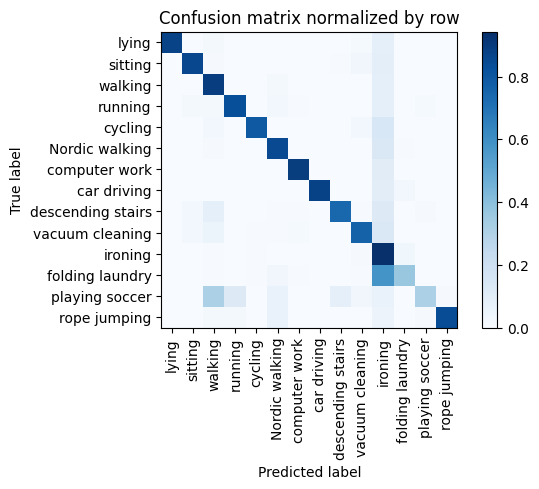

Training Epoch:  10%|█         | 1/10 [00:27<04:11, 27.91s/it]

Overall accuracy: 0.821



seen: 100%|██████████| 130/130 [00:10<00:00, 12.00batch/s, loss=0.122]


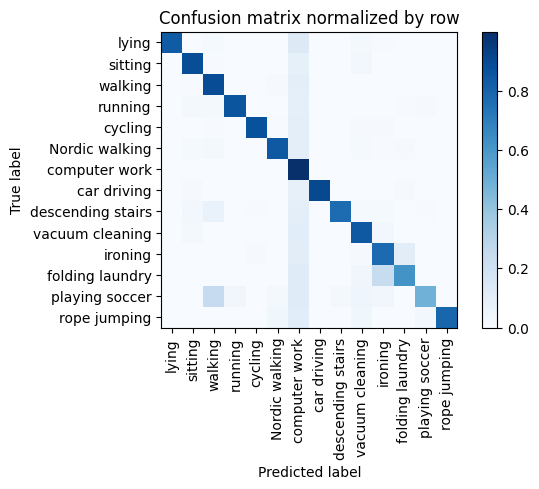

Training Epoch:  20%|██        | 2/10 [00:56<03:46, 28.37s/it]

Overall accuracy: 0.845



seen: 100%|██████████| 130/130 [00:11<00:00, 11.13batch/s, loss=0.129]


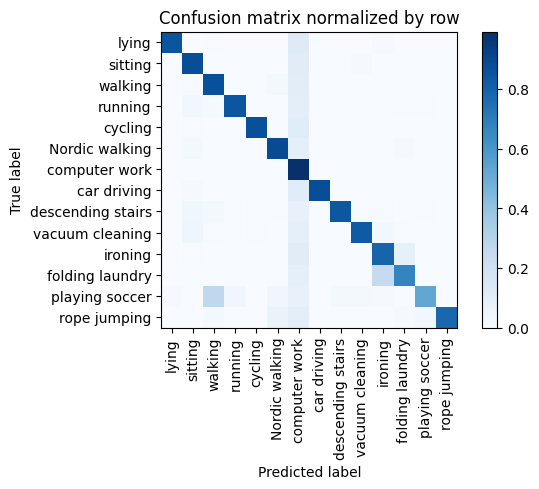

Training Epoch:  30%|███       | 3/10 [01:30<03:37, 31.12s/it]

Overall accuracy: 0.856



seen: 100%|██████████| 130/130 [00:11<00:00, 11.10batch/s, loss=0.0925]


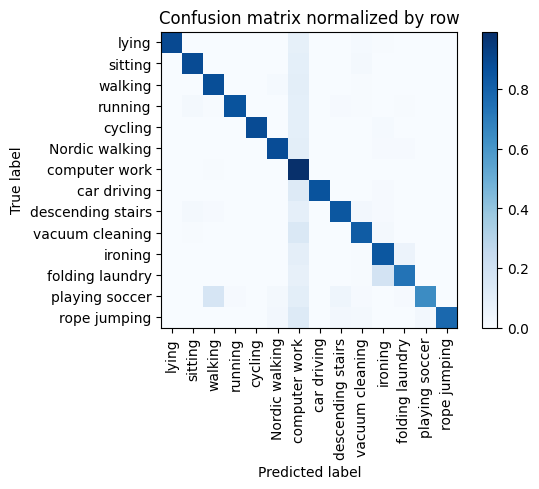

Training Epoch:  40%|████      | 4/10 [02:03<03:09, 31.55s/it]

Overall accuracy: 0.872



seen: 100%|██████████| 130/130 [00:10<00:00, 12.44batch/s, loss=0.0921]


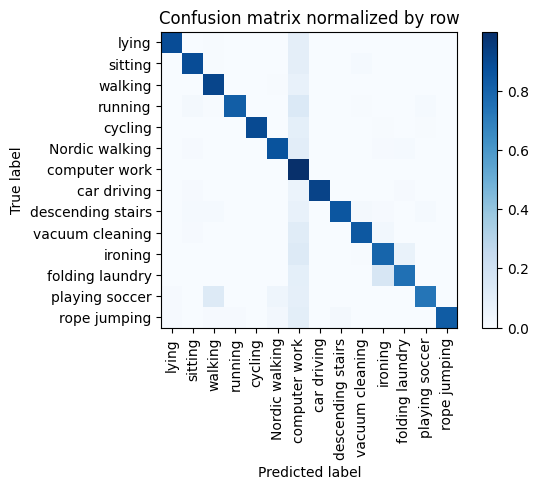

Training Epoch:  50%|█████     | 5/10 [02:32<02:33, 30.61s/it]

Overall accuracy: 0.876



seen: 100%|██████████| 130/130 [00:10<00:00, 12.33batch/s, loss=0.0764]


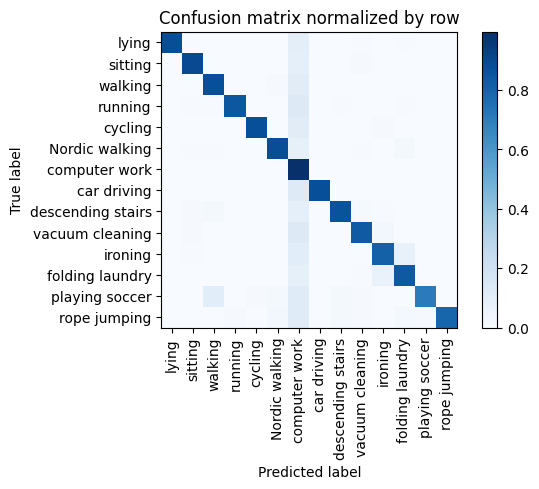

Training Epoch:  60%|██████    | 6/10 [03:01<02:00, 30.11s/it]

Overall accuracy: 0.875



seen: 100%|██████████| 130/130 [00:10<00:00, 12.69batch/s, loss=0.0629]


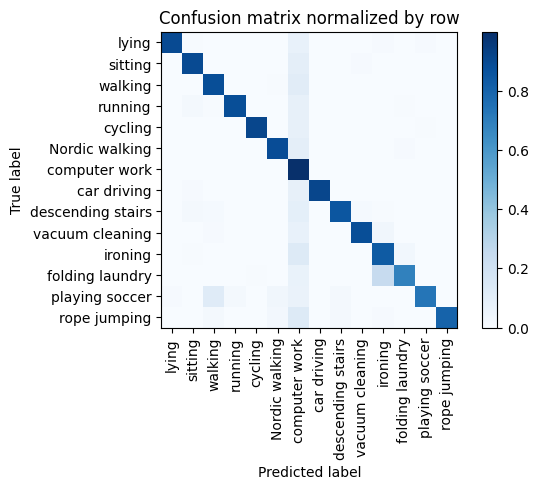

Training Epoch:  70%|███████   | 7/10 [03:27<01:26, 28.87s/it]

Overall accuracy: 0.883



seen: 100%|██████████| 130/130 [00:10<00:00, 12.36batch/s, loss=0.0752]


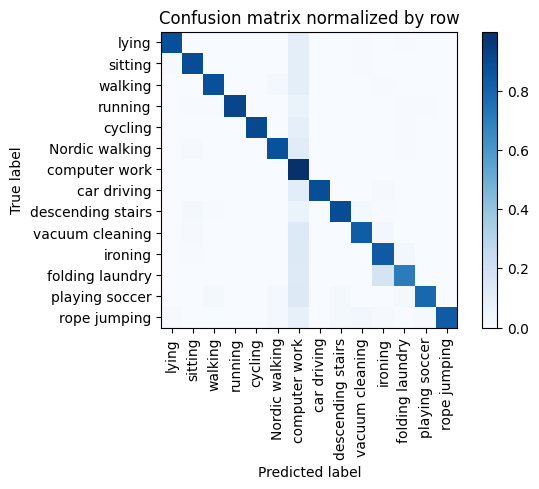

Training Epoch:  80%|████████  | 8/10 [03:53<00:55, 27.77s/it]

Overall accuracy: 0.879



seen: 100%|██████████| 130/130 [00:11<00:00, 11.61batch/s, loss=0.0635]


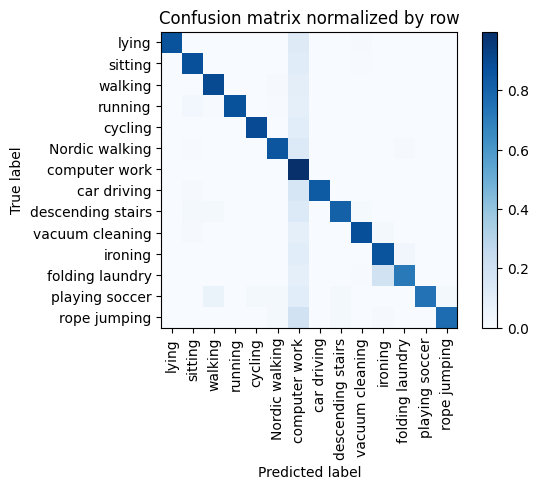

Training Epoch:  90%|█████████ | 9/10 [04:18<00:27, 27.18s/it]

Overall accuracy: 0.873



seen: 100%|██████████| 130/130 [00:10<00:00, 12.46batch/s, loss=0.0607]


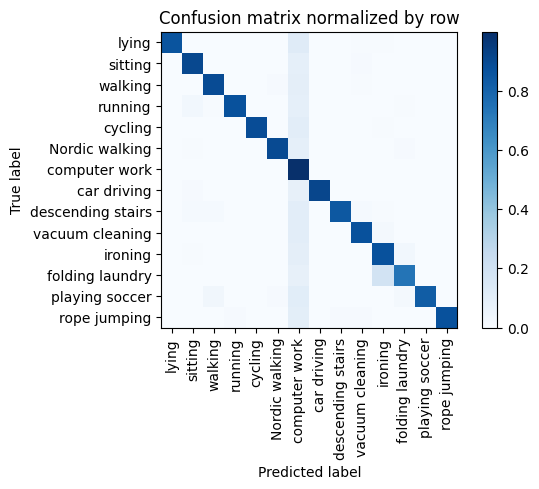

Overall accuracy: 0.889



unseen: 100%|██████████| 175/175 [00:16<00:00, 10.33batch/s, loss=0.0147]


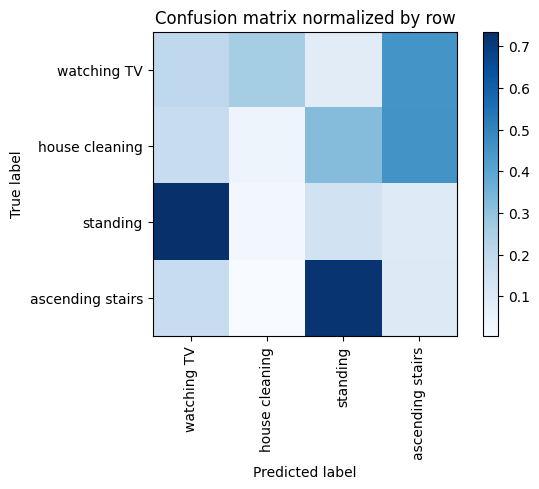

Overall accuracy: 0.110

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.158      0.146      0.152      0.331       1852|	 watching TV: 0.735,	ascending stairs: 0.094,	
  house cleaning       0.219      0.041      0.069      0.328       1837|	 ascending stairs: 0.457,	standing: 0.322,	watching TV: 0.180,	
ascending stairs       0.069      0.095      0.080      0.193       1081|	 standing: 0.722,	watching TV: 0.179,	
     watching TV       0.080      0.199      0.115      0.148        830|	 ascending stairs: 0.454,	house cleaning: 0.261,	

----------------------------------------------------------------------------------------------------
     avg / total       0.149      0.110      0.105        1.0       5600|	      

{'accuracy': 0.10964285714285714, 'precision': 0.13170954296297274, 'recall': 0.1203082641643429, 'f1': 0.10385331915694355}
================ Fold-1 ================
Initiate IMU datasets ...
Initiate Sk

seen: 100%|██████████| 131/131 [00:10<00:00, 12.24batch/s, loss=0.199]


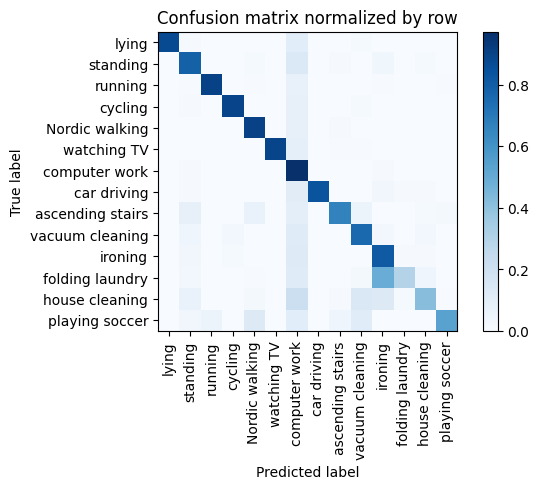

Training Epoch:  10%|█         | 1/10 [00:22<03:25, 22.80s/it]

Overall accuracy: 0.783



seen: 100%|██████████| 131/131 [00:10<00:00, 12.29batch/s, loss=0.157]


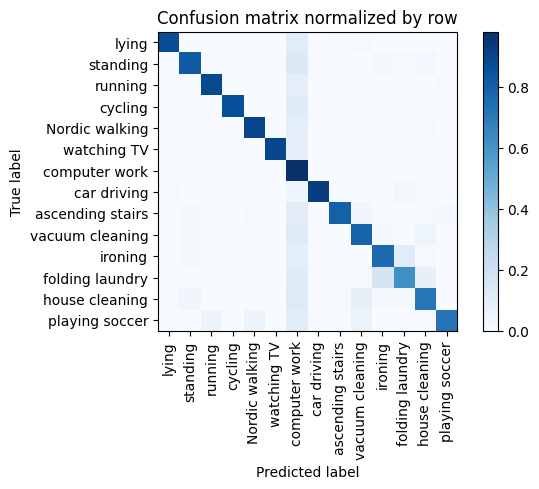

Training Epoch:  20%|██        | 2/10 [00:45<03:03, 22.99s/it]

Overall accuracy: 0.834



seen: 100%|██████████| 131/131 [00:10<00:00, 12.26batch/s, loss=0.125]


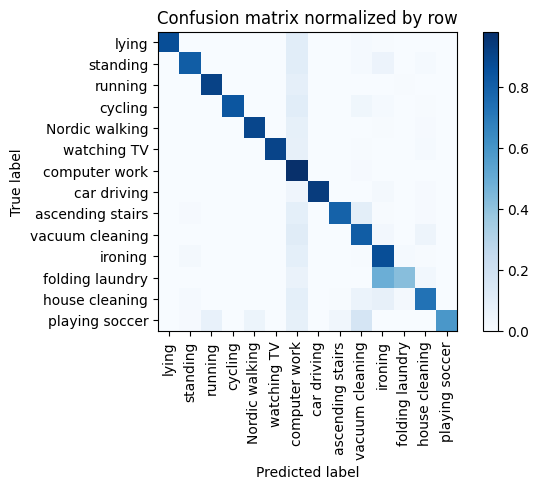

Training Epoch:  30%|███       | 3/10 [01:08<02:39, 22.85s/it]

Overall accuracy: 0.835



seen: 100%|██████████| 131/131 [00:10<00:00, 12.26batch/s, loss=0.114]


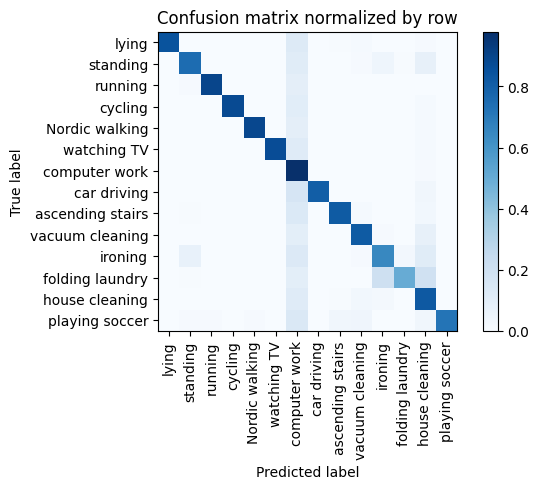

Training Epoch:  40%|████      | 4/10 [01:31<02:16, 22.83s/it]

Overall accuracy: 0.818



seen: 100%|██████████| 131/131 [00:10<00:00, 12.07batch/s, loss=0.0959]


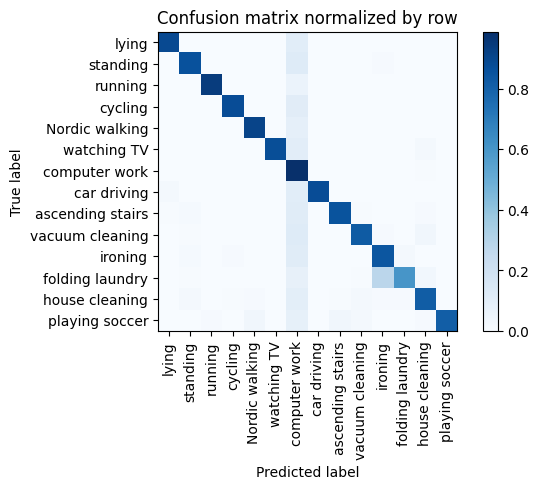

Training Epoch:  50%|█████     | 5/10 [01:54<01:54, 22.95s/it]

Overall accuracy: 0.870



seen: 100%|██████████| 131/131 [00:12<00:00, 10.36batch/s, loss=0.0999]


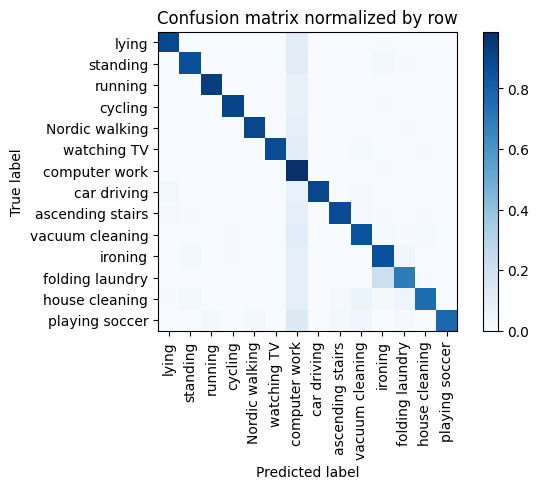

Training Epoch:  60%|██████    | 6/10 [02:19<01:34, 23.66s/it]

Overall accuracy: 0.875



seen: 100%|██████████| 131/131 [00:11<00:00, 11.10batch/s, loss=0.08]


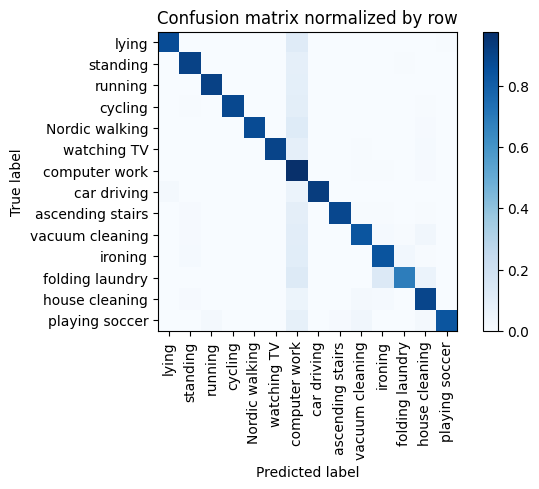

Training Epoch:  70%|███████   | 7/10 [02:43<01:11, 23.74s/it]

Overall accuracy: 0.881



seen: 100%|██████████| 131/131 [00:10<00:00, 12.29batch/s, loss=0.0892]


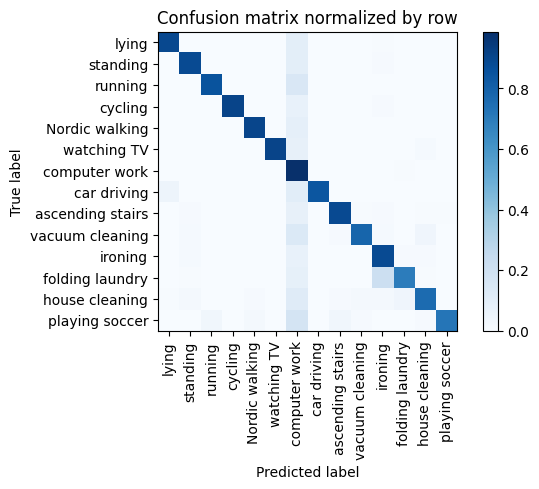

Training Epoch:  80%|████████  | 8/10 [03:06<00:47, 23.54s/it]

Overall accuracy: 0.871



seen: 100%|██████████| 131/131 [00:10<00:00, 12.12batch/s, loss=0.0733]


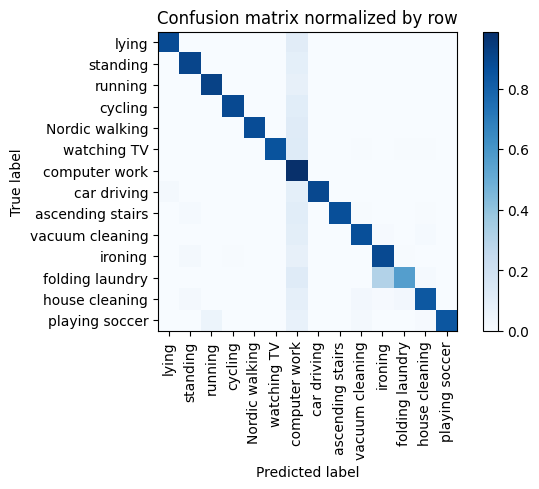

Training Epoch:  90%|█████████ | 9/10 [03:29<00:23, 23.28s/it]

Overall accuracy: 0.880



seen: 100%|██████████| 131/131 [00:10<00:00, 12.21batch/s, loss=0.0689]


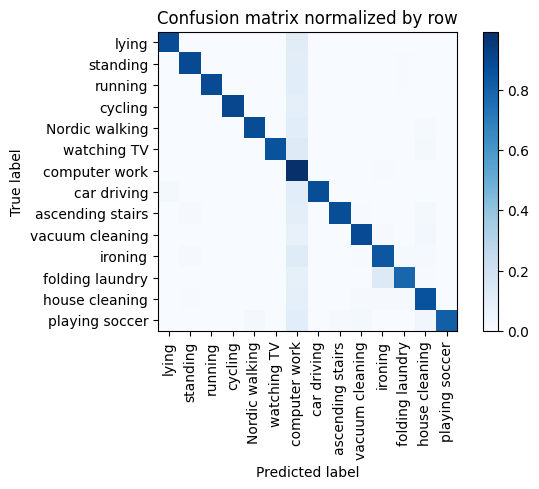

Overall accuracy: 0.888



unseen: 100%|██████████| 173/173 [00:15<00:00, 10.87batch/s, loss=0.0209]


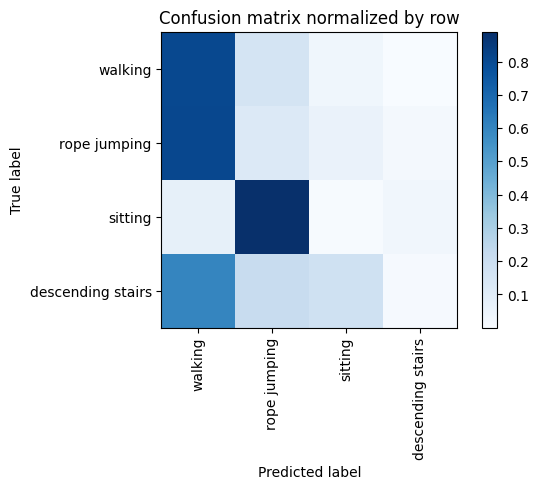

Overall accuracy: 0.353

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.637      0.805      0.711      0.421       2329|	 rope jumping: 0.160,	sitting: 0.034,	
          sitting       0.045      0.007      0.012      0.325       1799|	 rope jumping: 0.889,	walking: 0.074,	descending stairs: 0.029,	
descending stairs       0.141      0.011      0.020      0.172        950|	 walking: 0.595,	rope jumping: 0.215,	sitting: 0.180,	
     rope jumping       0.025      0.120      0.041      0.083        458|	 walking: 0.808,	sitting: 0.057,	

----------------------------------------------------------------------------------------------------
      avg / total       0.309      0.353      0.310        1.0       5536|	      

{'accuracy': 0.35278179190751446, 'precision': 0.21185480714838095, 'recall': 0.23572661025013725, 'f1': 0.19605799649174796}
================ Fold-2 ================
Initiate IMU datasets ...
Initiate Sk

seen: 100%|██████████| 121/121 [00:09<00:00, 12.41batch/s, loss=0.203]


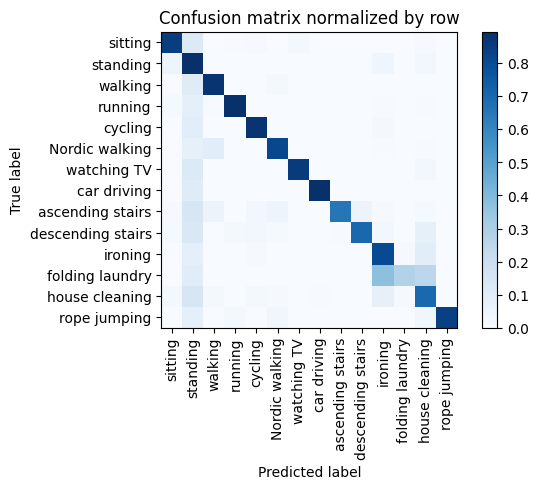

Training Epoch:  10%|█         | 1/10 [00:21<03:14, 21.63s/it]

Overall accuracy: 0.794



seen: 100%|██████████| 121/121 [00:10<00:00, 11.96batch/s, loss=0.162]


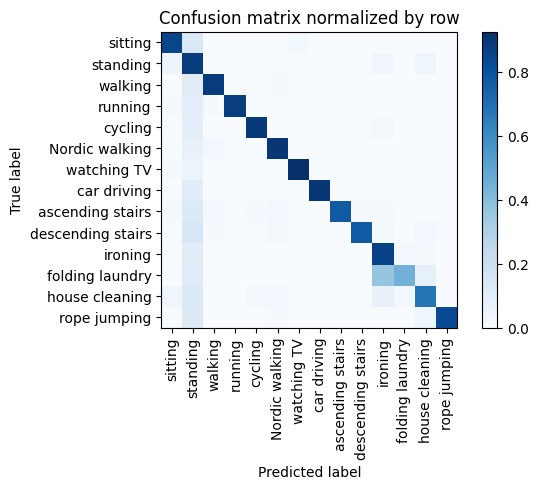

Training Epoch:  20%|██        | 2/10 [00:43<02:53, 21.64s/it]

Overall accuracy: 0.830



seen: 100%|██████████| 121/121 [00:09<00:00, 12.32batch/s, loss=0.115]


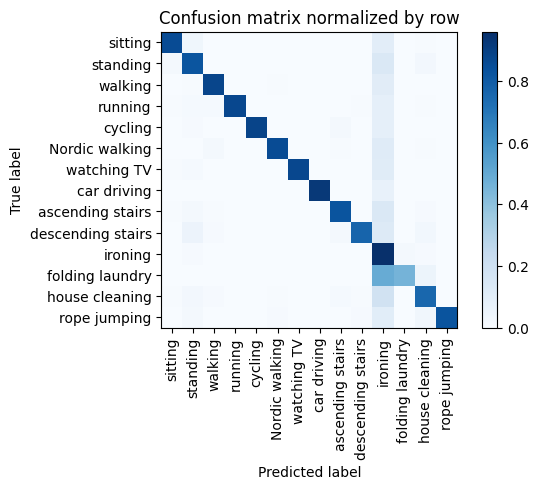

Training Epoch:  30%|███       | 3/10 [01:04<02:30, 21.51s/it]

Overall accuracy: 0.841



seen: 100%|██████████| 121/121 [00:09<00:00, 12.26batch/s, loss=0.111]


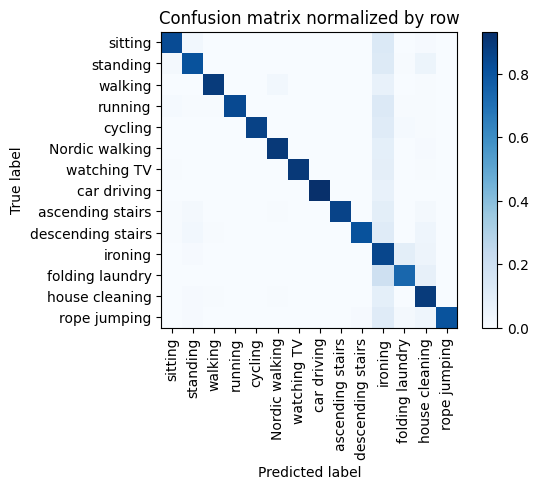

Training Epoch:  40%|████      | 4/10 [01:26<02:09, 21.61s/it]

Overall accuracy: 0.856



seen: 100%|██████████| 121/121 [00:09<00:00, 12.21batch/s, loss=0.103]


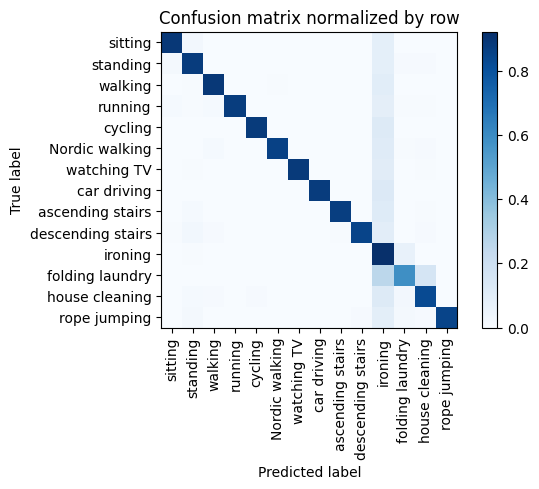

Training Epoch:  50%|█████     | 5/10 [01:47<01:47, 21.50s/it]

Overall accuracy: 0.864



seen: 100%|██████████| 121/121 [00:09<00:00, 12.50batch/s, loss=0.0946]


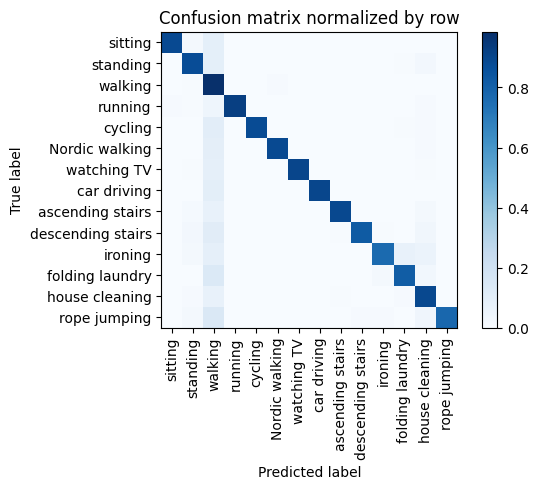

Training Epoch:  60%|██████    | 6/10 [02:08<01:25, 21.34s/it]

Overall accuracy: 0.875



seen: 100%|██████████| 121/121 [00:09<00:00, 12.39batch/s, loss=0.0855]


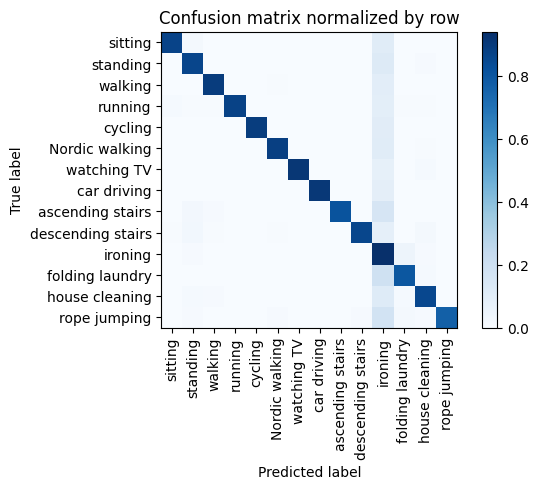

Training Epoch:  70%|███████   | 7/10 [02:30<01:04, 21.34s/it]

Overall accuracy: 0.875



seen: 100%|██████████| 121/121 [00:09<00:00, 12.28batch/s, loss=0.0829]


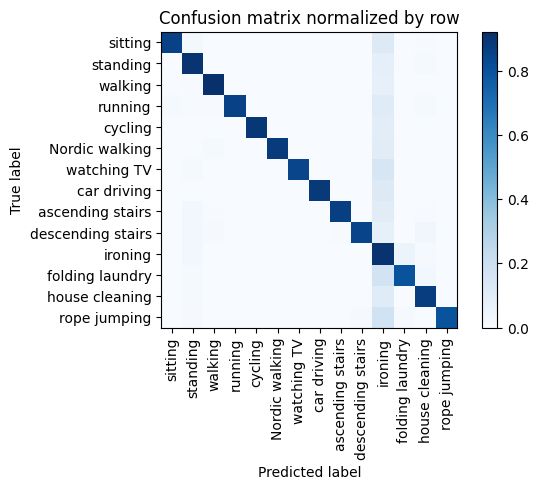

Training Epoch:  80%|████████  | 8/10 [02:51<00:42, 21.44s/it]

Overall accuracy: 0.877



seen: 100%|██████████| 121/121 [00:09<00:00, 12.10batch/s, loss=0.0777]


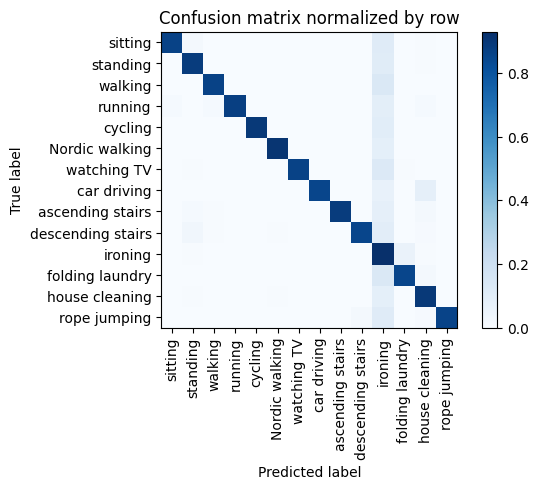

Training Epoch:  90%|█████████ | 9/10 [03:13<00:21, 21.58s/it]

Overall accuracy: 0.883



seen: 100%|██████████| 121/121 [00:10<00:00, 11.70batch/s, loss=0.0647]


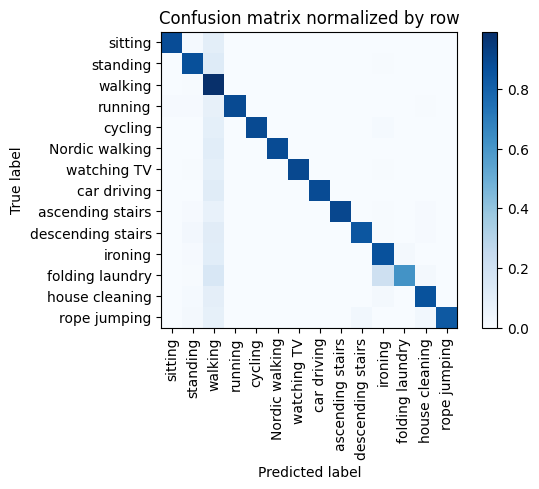

Overall accuracy: 0.877



unseen: 100%|██████████| 222/222 [00:19<00:00, 11.13batch/s, loss=0.0263]


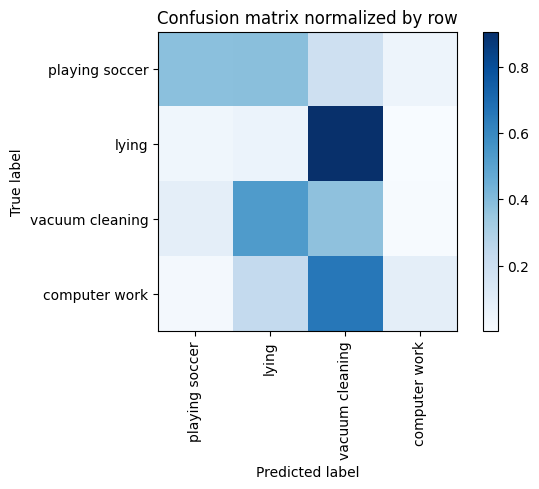

Overall accuracy: 0.168

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.869      0.088      0.160      0.432       3066|	 vacuum cleaning: 0.656,	lying: 0.233,	
          lying       0.055      0.056      0.056      0.264       1876|	 vacuum cleaning: 0.906,	playing soccer: 0.035,	
vacuum cleaning       0.144      0.375      0.208      0.240       1704|	 lying: 0.529,	playing soccer: 0.087,	
 playing soccer       0.382      0.382      0.382      0.064        458|	 lying: 0.384,	vacuum cleaning: 0.188,	

----------------------------------------------------------------------------------------------------
    avg / total       0.449      0.168      0.158 0.9999999999999999       7104|	      

{'accuracy': 0.16751126126126126, 'precision': 0.3625131485362004, 'recall': 0.22536374982308224, 'f1': 0.20157852394618253}
================ Fold-3 ================
Initiate IMU datasets ...
Initiate Skeleton dataset ... 
Initial Mo

seen: 100%|██████████| 138/138 [00:11<00:00, 12.23batch/s, loss=0.152]


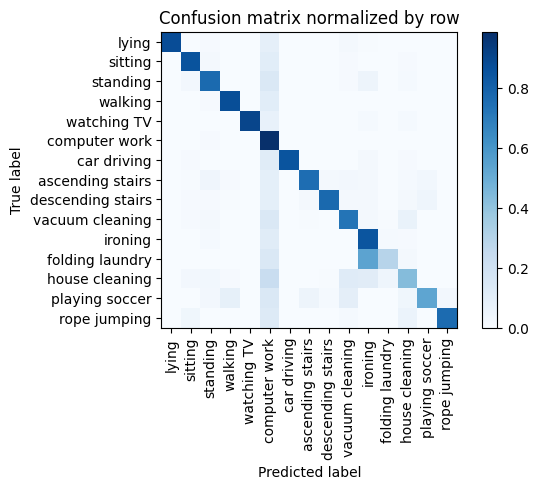

Training Epoch:  10%|█         | 1/10 [00:23<03:35, 23.96s/it]

Overall accuracy: 0.786



seen: 100%|██████████| 138/138 [00:11<00:00, 12.42batch/s, loss=0.132]


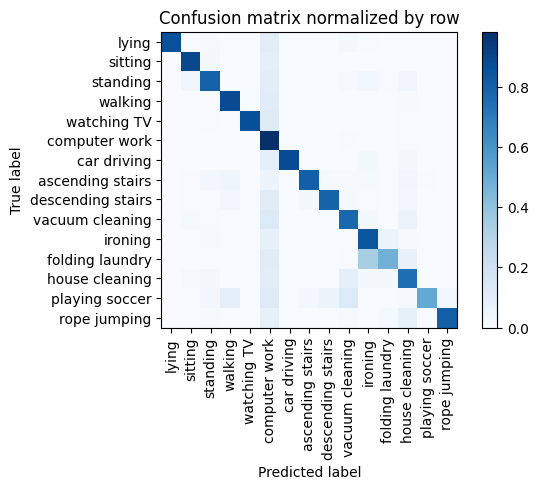

Training Epoch:  20%|██        | 2/10 [00:47<03:10, 23.76s/it]

Overall accuracy: 0.829



seen: 100%|██████████| 138/138 [00:08<00:00, 15.42batch/s, loss=0.109]


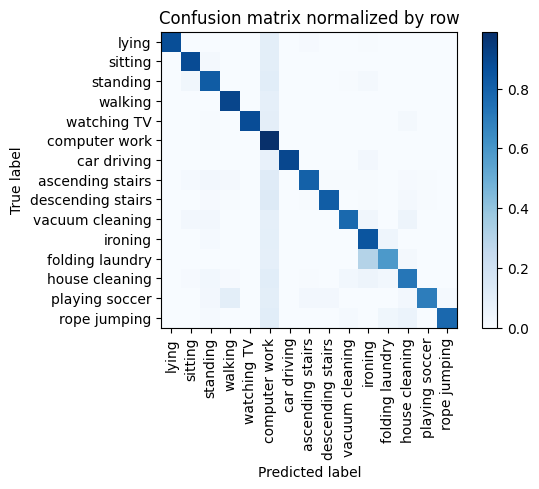

Training Epoch:  30%|███       | 3/10 [01:09<02:39, 22.72s/it]

Overall accuracy: 0.845



seen: 100%|██████████| 138/138 [00:09<00:00, 14.62batch/s, loss=0.112]


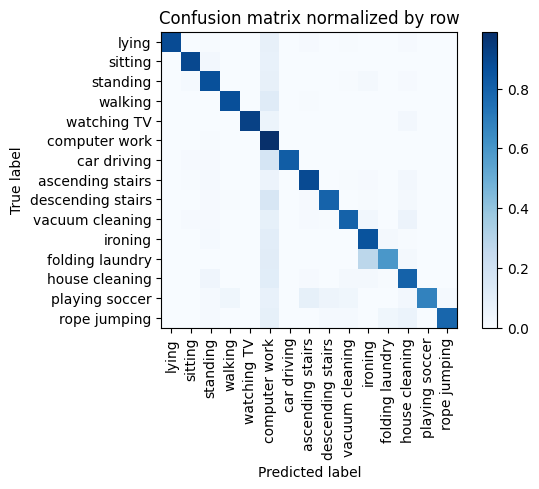

Training Epoch:  40%|████      | 4/10 [01:31<02:15, 22.57s/it]

Overall accuracy: 0.859



seen: 100%|██████████| 138/138 [00:11<00:00, 12.18batch/s, loss=0.0978]


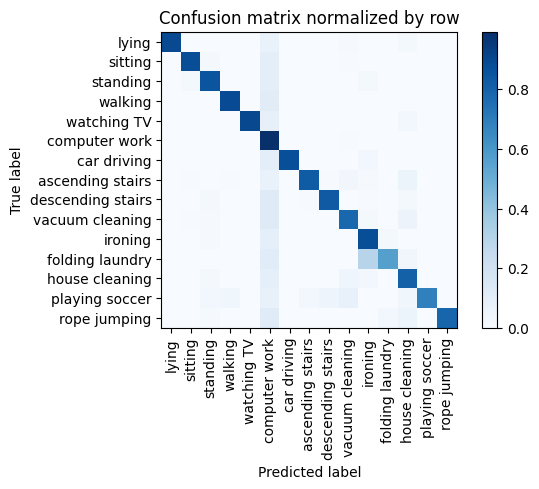

Training Epoch:  50%|█████     | 5/10 [01:55<01:55, 23.17s/it]

Overall accuracy: 0.859



seen: 100%|██████████| 138/138 [00:11<00:00, 12.12batch/s, loss=0.097]


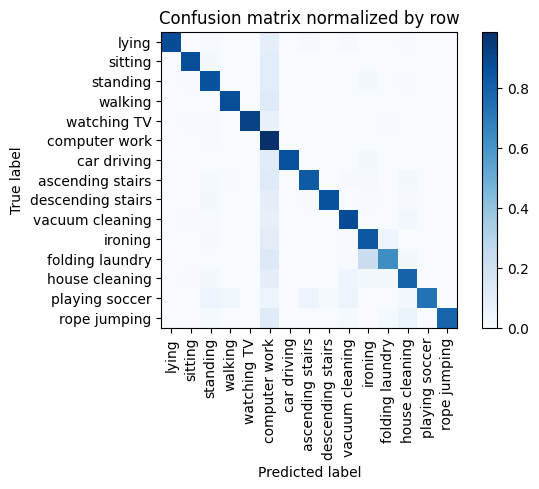

Training Epoch:  60%|██████    | 6/10 [02:19<01:33, 23.47s/it]

Overall accuracy: 0.864



seen: 100%|██████████| 138/138 [00:11<00:00, 12.30batch/s, loss=0.0806]


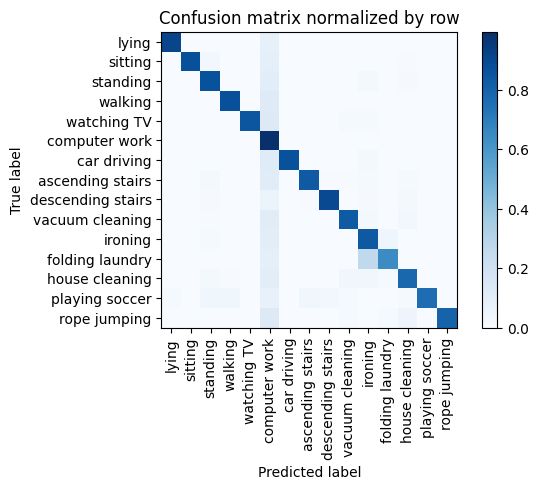

Training Epoch:  70%|███████   | 7/10 [02:43<01:10, 23.57s/it]

Overall accuracy: 0.863



seen: 100%|██████████| 138/138 [00:11<00:00, 12.15batch/s, loss=0.0708]


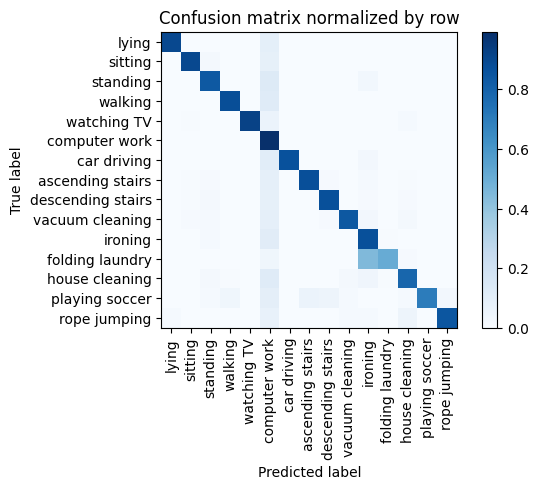

Training Epoch:  80%|████████  | 8/10 [03:07<00:47, 23.68s/it]

Overall accuracy: 0.864



seen: 100%|██████████| 138/138 [00:10<00:00, 12.99batch/s, loss=0.0646]


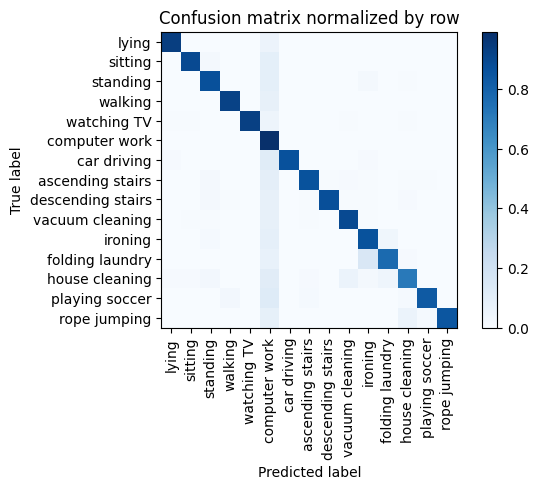

Training Epoch:  90%|█████████ | 9/10 [03:30<00:23, 23.53s/it]

Overall accuracy: 0.884



seen: 100%|██████████| 138/138 [00:07<00:00, 18.14batch/s, loss=0.0691]


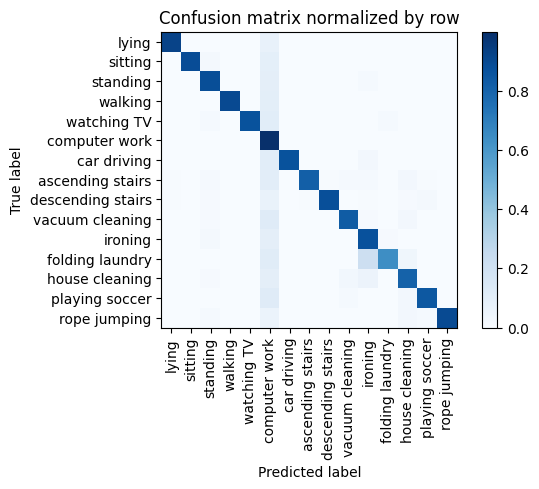

Overall accuracy: 0.878



unseen: 100%|██████████| 137/137 [00:07<00:00, 17.21batch/s, loss=0.0227]


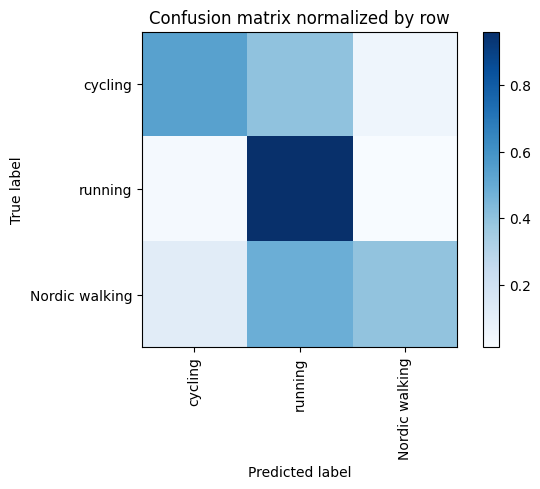

Overall accuracy: 0.571

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.873      0.397      0.545      0.419       1838|	 running: 0.484,	cycling: 0.119,	
       cycling       0.780      0.541      0.639      0.365       1600|	 running: 0.401,	Nordic walking: 0.058,	
       running       0.372      0.959      0.536      0.216        946|	 cycling: 0.026,	Nordic walking: 0.015,	

----------------------------------------------------------------------------------------------------
   avg / total       0.731      0.571      0.578        1.0       4384|	      

{'accuracy': 0.5707116788321168, 'precision': 0.6750359303776454, 'recall': 0.6322168508605042, 'f1': 0.5734875283491657}
================ Fold-4 ================
Initiate IMU datasets ...
Initiate Skeleton dataset ... 
Initial Models ...
Start Models training ...


seen: 100%|██████████| 141/141 [00:07<00:00, 18.24batch/s, loss=0.179]


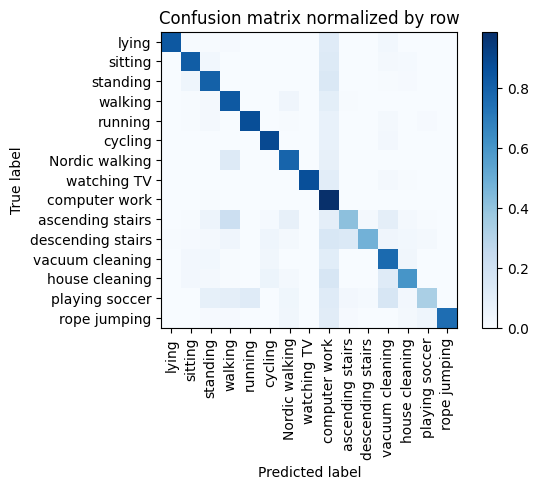

Training Epoch:  10%|█         | 1/10 [00:20<03:06, 20.75s/it]

Overall accuracy: 0.783



seen: 100%|██████████| 141/141 [00:07<00:00, 18.28batch/s, loss=0.157]


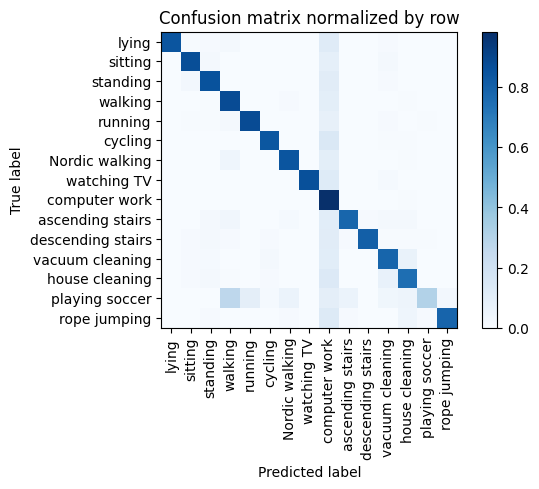

Training Epoch:  20%|██        | 2/10 [00:41<02:44, 20.55s/it]

Overall accuracy: 0.844



seen: 100%|██████████| 141/141 [00:07<00:00, 18.29batch/s, loss=0.135]


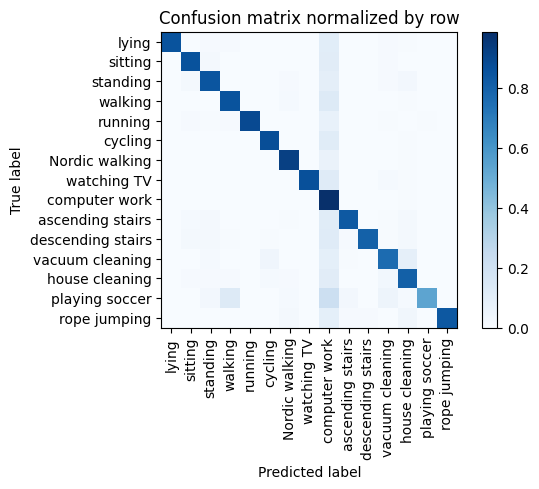

Training Epoch:  30%|███       | 3/10 [01:02<02:25, 20.79s/it]

Overall accuracy: 0.860



seen: 100%|██████████| 141/141 [00:07<00:00, 17.72batch/s, loss=0.0987]


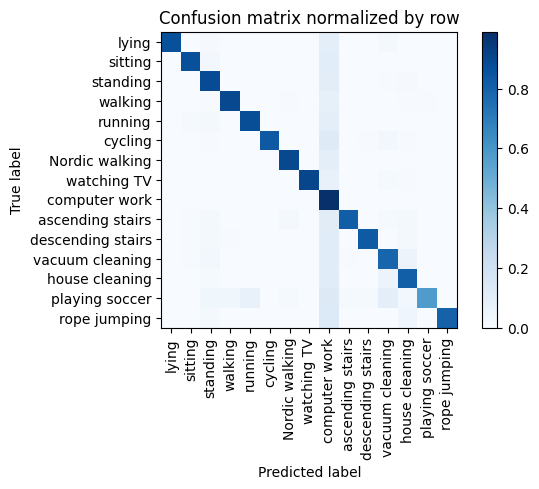

Training Epoch:  40%|████      | 4/10 [01:24<02:09, 21.53s/it]

Overall accuracy: 0.869



seen: 100%|██████████| 141/141 [00:07<00:00, 17.98batch/s, loss=0.0933]


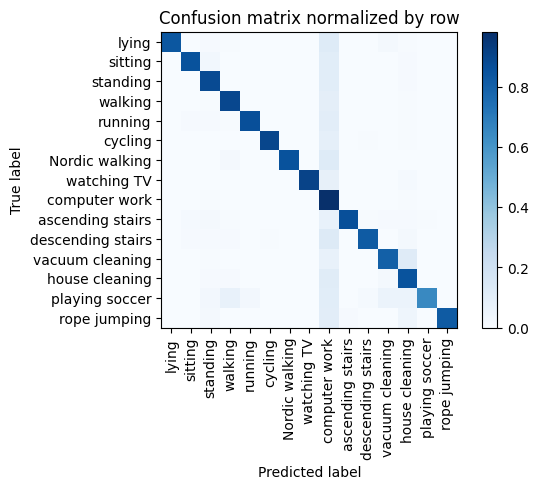

Training Epoch:  50%|█████     | 5/10 [01:45<01:46, 21.24s/it]

Overall accuracy: 0.873



seen: 100%|██████████| 141/141 [00:07<00:00, 18.42batch/s, loss=0.0864]


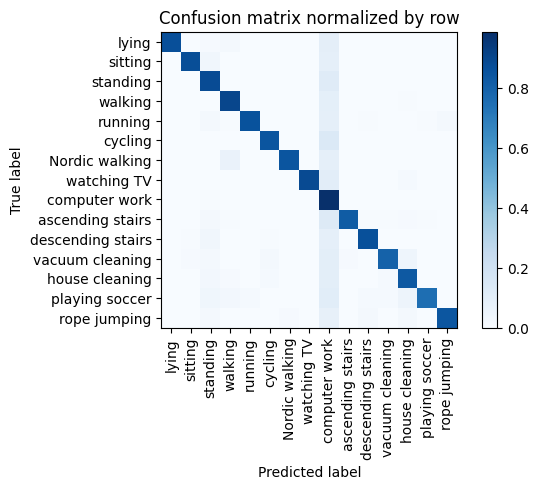

Training Epoch:  60%|██████    | 6/10 [02:08<01:27, 21.81s/it]

Overall accuracy: 0.874



seen: 100%|██████████| 141/141 [00:11<00:00, 12.18batch/s, loss=0.0739]


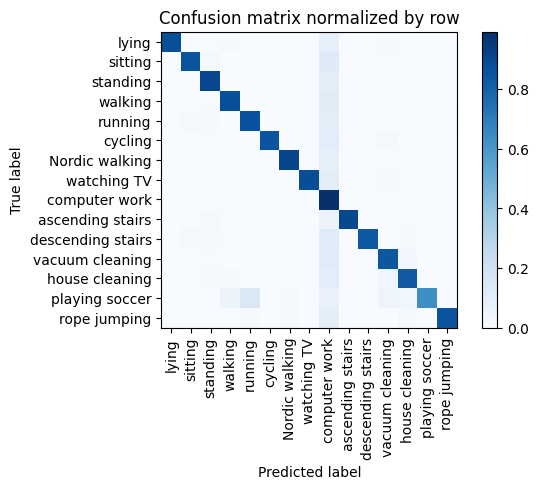

Training Epoch:  70%|███████   | 7/10 [02:36<01:11, 23.81s/it]

Overall accuracy: 0.881



seen: 100%|██████████| 141/141 [00:11<00:00, 12.33batch/s, loss=0.0773]


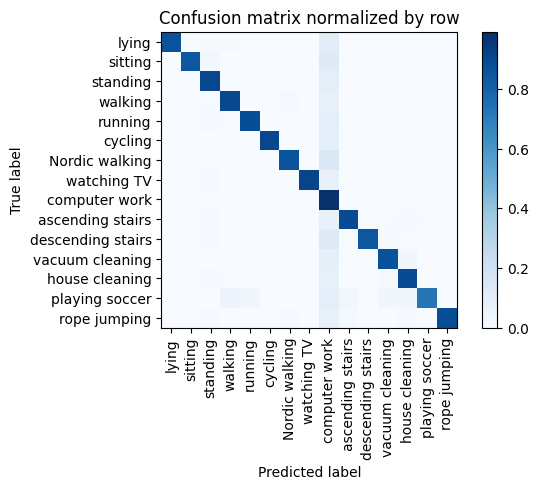

Training Epoch:  80%|████████  | 8/10 [03:00<00:47, 23.88s/it]

Overall accuracy: 0.889



seen: 100%|██████████| 141/141 [00:08<00:00, 15.81batch/s, loss=0.0619]


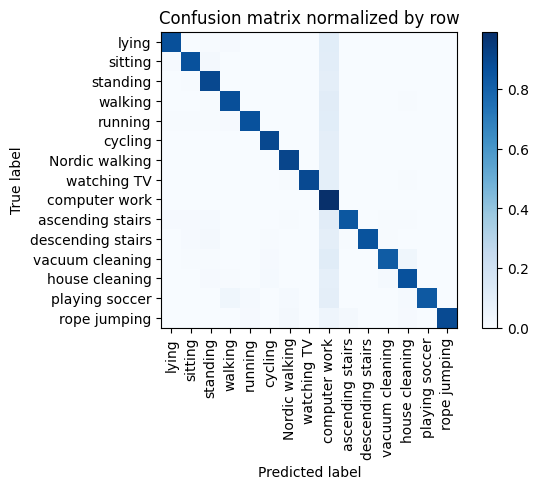

Training Epoch:  90%|█████████ | 9/10 [03:21<00:23, 23.13s/it]

Overall accuracy: 0.890



seen: 100%|██████████| 141/141 [00:08<00:00, 17.17batch/s, loss=0.0615]


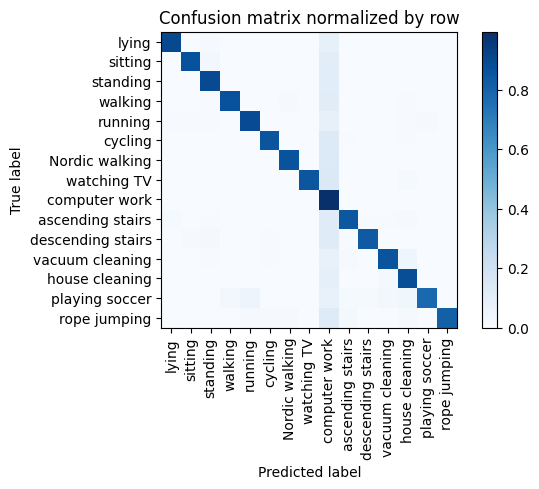

Overall accuracy: 0.883



unseen: 100%|██████████| 120/120 [00:11<00:00, 10.86batch/s, loss=0.0202]


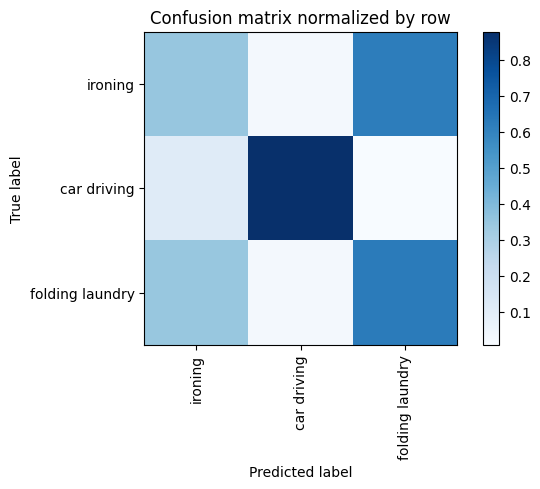

Overall accuracy: 0.494

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.674      0.350      0.461      0.608       2334|	 folding laundry: 0.620,	car driving: 0.030,	
folding laundry       0.295      0.627      0.401      0.253        970|	 ironing: 0.346,	car driving: 0.027,	
    car driving       0.832      0.879      0.855      0.140        536|	 ironing: 0.112,	folding laundry: 0.009,	

----------------------------------------------------------------------------------------------------
    avg / total       0.600      0.494      0.501        1.0       3840|	      

{'accuracy': 0.4940104166666667, 'precision': 0.6003689031392402, 'recall': 0.6186689203036487, 'f1': 0.5724114724004498}
============== Overall Unseen Classes Performance ==============


accuracy     0.338932
precision    0.396296
recall       0.366457
f1           0.329478
dtype: float64

In [36]:
prep_dir = './tmp/epoch50_randsample_input_mseloss.pt'

fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    # print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']

    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    print("Initiate Skeleton dataset ... ")
    # build Skeleton dataset 
    skel_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=config['seq_len'])
    skel_dl = DataLoader(skel_dt, batch_size=config['batch_size']//2, shuffle=True, pin_memory=True, drop_last=True)
    skel_n, skel_fts = skel_dt.getShape()
    
    print("Initial Models ...")
    # build IMU Encoder Model 
    imu_model = Model6a(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=config['feat_size'], max_len=seq_len, n_classes=len(seen_classes))
    imu_model.to(device)

    # build AE Model 
    # ae_model = BiLSTMEncDecModel(input_size=skel_fts, seq_len=skel_n, hidden_size=config['feat_size'], batch_size=config['batch_size'], ae_type='recursive', device=device)
    ae_model = BiLSTMEncDecModel(seq_len=skel_n, input_size=skel_fts, hidden_size=512, linear_filters=[128,256,512], embedding_size=config['feat_size'], num_layers=1, bidirectional=True, batch_size=config['batch_size'], device=device)
    # ae_model = BiLSTMEncDecModel(seq_len=50, input_size=36, hidden_size=512, linear_filters=[128,256,512], embedding_size=256, num_layers=1,bidirectional=True,batch_size=32, device=device)
    # ae_model.load_state_dict(torch.load(prep_dir))
    ae_model.to(device)
    
    # define IMU-Enc run parameters 
    imu_optim = Adam(imu_model.parameters(), lr=config['imu_lr'])
    imu_loss_module = {'class': nn.CrossEntropyLoss(), 'feature': L1Loss()}
    best_acc = 0.0

    # define AE run parameters 
    ae_optim = Adam(ae_model.parameters(), lr=config['ae_lr'])
    ae_loss_module = {'contrast': SupConLoss(contrast_mode='one'), 'recons': nn.MSELoss()}

    print("Start Models training ...")
    # train 2 models E2E
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        # train AE model 
        ae_train_metrics = ae_train_step1(ae_model, skel_dl, ae_optim, ae_loss_module, device, config['batch_size'], phase='train', loss_alpha=config['ae_alpha'])
        # train IMU-Enc model
        train_metrics = imu_train_step1(imu_model, ae_model, train_dl, skel_dt, imu_optim, imu_loss_module, device, class_names=[all_classes[i] for i in seen_classes], class_ids=seen_classes, phase='train', loss_alpha=config['imu_alpha'], batch_size=32)
        eval_metrics = eval_step1(imu_model, ae_model, eval_dl, skel_dt, imu_loss_module, device=device, class_names=[all_classes[i] for i in seen_classes], class_ids=seen_classes,  target_feat_met=eval_dt.getClassAttrs(), phase='seen', print_report=False, loss_alpha=config['imu_alpha'], batch_size=config['batch_size'], show_plot=True)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            imu_best_model = deepcopy(imu_model.state_dict())

    # replace by best model 
    imu_model.load_state_dict(imu_best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step1(imu_model, ae_model, test_dl, skel_dt, imu_loss_module, device=device, class_names=[all_classes[i] for i in unseen_classes], class_ids=unseen_classes,  target_feat_met=test_dt.getClassAttrs(), phase='unseen', loss_alpha=0.8, batch_size=config['batch_size'])
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    